## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

<a id='0-bullet'></a>
## Содержание

* [1. Предобработка](#1-bullet)
* [2. Анализ](#2-bullet)  
* [3. Обучение](#3-bullet) 
* [4. Тестирование](#5-bullet) 
* [5. Общий вывод](#6-bullet) 

<a id='1-bullet'></a>
### 1. Предобработка

[**Вернуться в содержание**](#0-bullet)

In [350]:
# стандартные модули
import pandas as pd
from scipy import stats as st
import numpy as np

# графика
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)})

# декомпозиция
from statsmodels.tsa.seasonal import seasonal_decompose

#ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

#time
import time

In [351]:
# загрузим датасет
df = pd.read_csv('/datasets/taxi.csv',
                 parse_dates=['datetime'], index_col='datetime')

In [352]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [353]:
df.isnull().sum()

num_orders    0
dtype: int64

In [354]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [355]:
# Начальная и конечные даты временного ряда
print(df.index.min())
print(df.index.max())

2018-03-01 00:00:00
2018-08-31 23:50:00


In [356]:
#Проверка сортировки индексов

df.index.is_monotonic

True

In [357]:
data = df.reset_index()

# Проверяем , есть ли временные разрывы в датасете
data['datetime'] = pd.to_datetime(data['datetime'])

(data['datetime'] - data['datetime'].shift()).value_counts()

00:10:00    26495
Name: datetime, dtype: int64

In [358]:
# удаляем ненужную копию
del data

In [359]:
# Делаем ресемплирование временного ряда, на скваженность в 1 час.
df = df.resample('1H').sum()

Имеется датасет содержащий информацию о количестве заказанных такси в аэропорту с интервалом в 10 минут в течение полугода, сет монотонный. 26400 строк, признак один - количество заказов.  
Интервал в 10 минут соблюдается на всем протяжение лога, пропусков в показаниях нет.  

<a id='2-bullet'></a>
# 2. Анализ

[**Вернуться в содержание**](#0-bullet)

Посмотрим на графическое представление данных

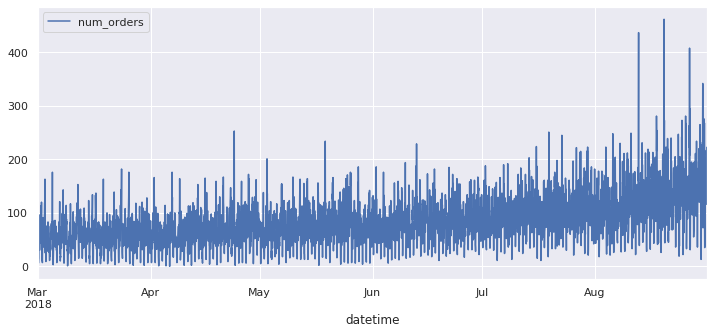

In [360]:
df.plot()

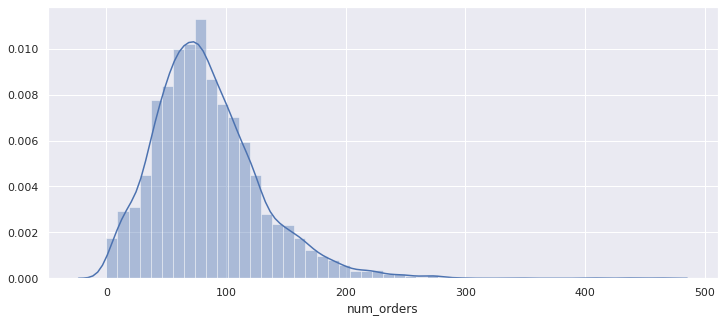

In [361]:
# Гистограмма
sns.distplot(df['num_orders'])

In [362]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

In [363]:
decomposed = seasonal_decompose(df) 

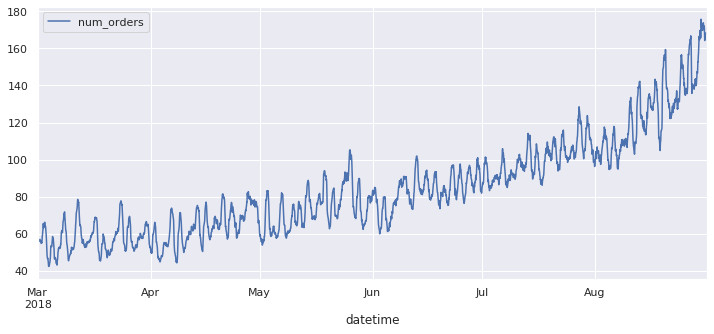

In [364]:
# Смотрим общий тренд представленного ряда
decomposed.trend.plot()

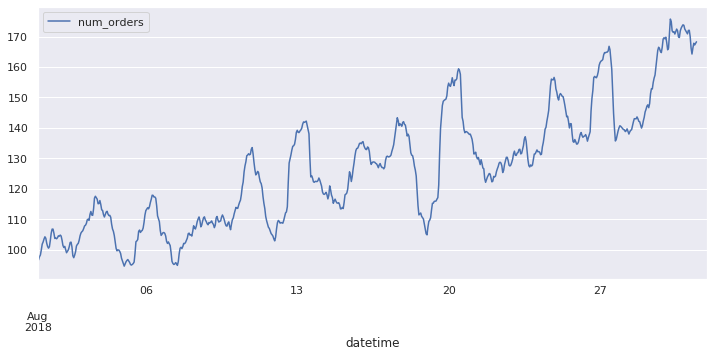

In [365]:
# смотрим месячный тренд 2018-08
decomposed.trend['2018-08-01':'2018-08-31'].plot()

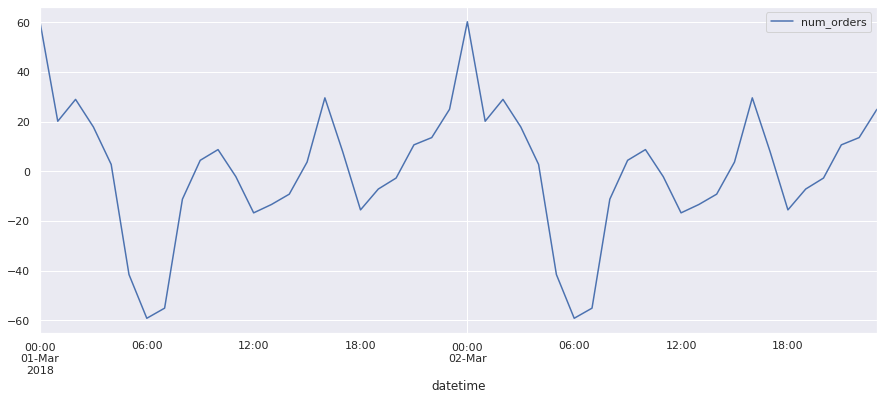

In [366]:
# Суточный ритм
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(15,6))

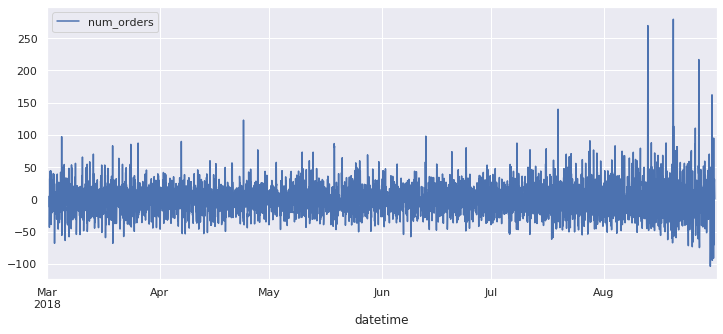

In [367]:
decomposed.resid.plot()

**Вывод:** Из декомпозиции видно что, иммется четкий тренд на увеличение числа заказов за время наблюдения. Так же можно отметить, что в течение суток максимум вызовов приходятся на 11, 17 и 0 часов, минимум на 6 утра.  
Медианное количество заказов 78, среднее 84 в час. 99% данных лежат в диапазоне от 0 до 220 заказов в час.  
Максимальный выброс 462 заказа за час.  

<a id='3-bullet'></a>
# 3. Обучение

[**Вернуться в содержание**](#0-bullet)

Для предсказания используем данные за прошлые периоды. Обучение будет строиться на двух типах данных предыдущие значения временного ряда, а так же скользящее среднее целевого признака построенное на исторических данных.  

Сделаем функцию, которая сформирует требуемые признаки.

In [409]:
def make_features(data, max_lag, rolling_mean_size):
    """
    Подготовка прзнаков для обучение модели. На вход получаем временной ряд, на выходе в ряд добавляются данные 
    с сдвигом в прошлое, а так же вычисляется скользящее среднее.
    Параметры: Максимальное количество сдвигов в прошлое и ширина окна для вычесления скользящего среднего. 
    """
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift()
    data['rolling_mean'] = data['rolling_mean'].rolling(rolling_mean_size).mean()

In [410]:
make_features(df,3,3)

In [412]:
# Удалим первые строки содержащие NaN
df = df.dropna()

# сет готов к обучению
df.head()

,num_orders,month,day,hour,dayofweek,sin,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,,
2018-03-01 12:00:00,30,3,1,12,3,1.224647e-16,96.0,64.0,69.0,76.333333
2018-03-01 13:00:00,32,3,1,13,3,-2.588190e-01,30.0,96.0,64.0,63.333333
2018-03-01 14:00:00,48,3,1,14,3,-5.000000e-01,32.0,30.0,96.0,52.666667
2018-03-01 15:00:00,66,3,1,15,3,-7.071068e-01,48.0,32.0,30.0,36.666667
2018-03-01 16:00:00,43,3,1,16,3,-8.660254e-01,66.0,48.0,32.0,48.666667


In [413]:
# делим данные на обучающие и целевой признак
y=df['num_orders']
X = df.drop(columns='num_orders')

In [414]:
# делим выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12345, shuffle=False)

In [415]:
# проверка
print('Размер обучающей выборки:', y_train.shape[0], '\n Размер тестовой выборки:', y_test.shape[0])

Размер обучающей выборки: 3963 
 Размер тестовой выборки: 441


LinearRegression

In [416]:
%%time
model_LR = LinearRegression()
 
model_LR.fit(X_train, y_train)
 
rmse_LR = mean_squared_error(y_test,model_LR.predict(X_test))**0.5
print('Среднеквадратическая ошибка линейной регрессии составляет {:.2f}\n'.format(rmse_LR))

Среднеквадратическая ошибка линейной регрессии составляет 52.19

CPU times: user 8.28 ms, sys: 0 ns, total: 8.28 ms
Wall time: 5.32 ms


RandomForestRegressor

In [313]:
# время работы 34min 56s

#%%time
#model_RFR = RandomForestRegressor(random_state = 12345)
#parametrs = { 'n_estimators': range (10, 51, 10),
#              'max_depth': range (1,80, 4),
#              'min_samples_leaf': range (1,4),
#               'min_samples_split': range (2,10,2)}

#grid = GridSearchCV(model_RFR, parametrs, cv=5)
#grid.fit(X_train, y_train)
#grid.best_params_

In [314]:
%%time
best_RF = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

rmse_RF = mean_squared_error(y_test,best_RF.fit(X_train, y_train).predict(X_test))**0.5
print('Среднеквадратическая ошибка случайного леса составляет {:.2f}\n'.format(rmse_RF))

Среднеквадратическая ошибка случайного леса составляет 47.63

CPU times: user 607 ms, sys: 3.25 ms, total: 610 ms
Wall time: 611 ms


CatBoost

In [315]:
%%time
model_CB = CatBoostRegressor(iterations=100, eval_metric='RMSE', verbose=False)

params = {'learning_rate': np.logspace(-3, 0, 5),
    'depth': [6, 8, 10]}

result = model_CB.grid_search(params, X_train, y=y_train, cv=3, verbose=False)

CPU times: user 48.2 s, sys: 5.6 s, total: 53.8 s
Wall time: 58.4 s


In [316]:
%%time
rmse_CB = (mean_squared_error(y_test, model_CB.predict(X_test))) ** 0.5
print('Среднеквадратическая ошибка CatBoostRegressor составляет {:.2f}\n'.format(rmse_CB))

Среднеквадратическая ошибка CatBoostRegressor составляет 46.96

CPU times: user 1.14 ms, sys: 12.5 ms, total: 13.7 ms
Wall time: 7.41 ms


LightGBM

In [406]:
gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=12345)


params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
}

grid_gbm = GridSearchCV(gbm,
                        params,
                        scoring='neg_mean_squared_error',
                        verbose=True)

In [407]:
%%time
#  total: 5min 2s

grid_gbm.fit(X_train, y_train)
grid_gbm.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   57.5s finished


CPU times: user 56.6 s, sys: 774 ms, total: 57.4 s
Wall time: 58.1 s


{'learning_rate': 0.1778279410038923, 'n_estimators': 40, 'num_leaves': 21}

{'learning_rate': 0.1778279410038923, 'n_estimators': 40, 'num_leaves': 21}

In [408]:
%%time

model_LGB = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1778279410038923,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=40, n_jobs=-1, num_leaves=21,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              seed=12345, silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0, verbose=0)

rmse_LGB = mean_squared_error(y_test,model_LGB.fit(X_train, y_train).predict(X_test))**0.5
print('Среднеквадратическая ошибка LightGBM составляет {:.2f}\n'.format(rmse_LGB))

Среднеквадратическая ошибка LightGBM составляет 42.98

CPU times: user 487 ms, sys: 12.8 ms, total: 500 ms
Wall time: 504 ms


**Вывод:**  Наилучший результат показал LGBMRegressor. Модель обучается быстро. Общее время работы алгоритма на имеющихся данных менее секунды (обучение и предсказание), так же он обладает минималной среднеквадратической ошибкой.  RMSE = 43.5.  
Условие заказчика о том, что значение метрики RMSE на тестовой выборке должно быть не больше 48 выполняется.

После удаления факторов года, месяца и дня RMSE стало хуже примерно на 10 %  Для изначально лучшего результата значение с 43.5 увеличилось до 49.80.  
Добавление назад только фактора дня ухудшило RMSE до 51.51  
Добавление назад только фактора месяца ухудшило RMSE до 47.53  
Добавление назад только фактора года  не повлияло на прогноз RMSE "без всего" 49.80  

Добавление назад только фактора дня и месяца дало наилучшую метрику RMSE 43.49

Так же проверил к чему приведет сокращение обучающих данных (возможно для предсказания на час данных за полгода будет избыточно) и сократил сет до 3 месяцев, в результате прогноз стал хуже  46.51

<a id='5-bullet'></a>
# 4. Тестирование

[**Вернуться в содержание**](#0-bullet)

In [320]:
y_pred = model_LGB.predict(X_test)

In [321]:
y_test.median()

135.0

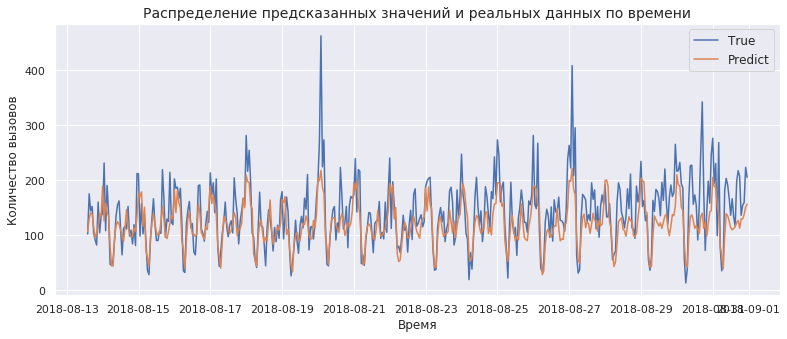

In [322]:
plt.figure(figsize=(13, 5))

plt.plot(y_test, label='True')
plt.plot(y_test.index, y_pred, label='Predict')

plt.title('Распределение предсказанных значений и реальных данных по времени', fontsize=14)
plt.xlabel('Время') # ось абсцисс
plt.ylabel('Количество вызовов') # ось абсцисс
plt.legend(fontsize=12)
plt.show()

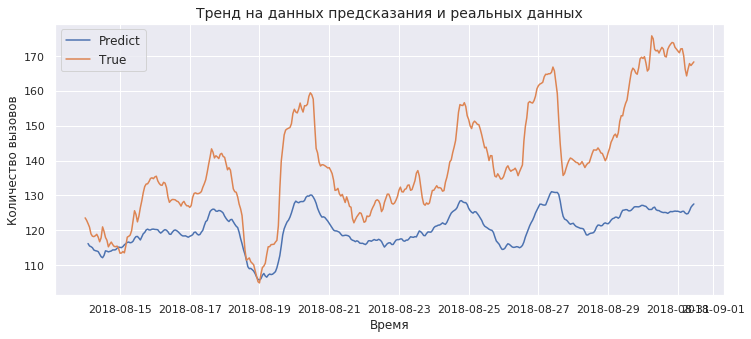

In [324]:
report = decomposed.trend['2018-08-14':'2018-08-31']
decomposed2.trend

sns.lineplot(x=decomposed2.trend.index, y='predict', data=decomposed2.trend, label='Predict')
sns.lineplot(x=report.index, y='num_orders', data=report, label='True')

plt.title('Тренд на данных предсказания и реальных данных', fontsize=14)
plt.xlabel('Время') # ось абсцисс
plt.ylabel('Количество вызовов') # ось абсцисс
plt.legend(fontsize=12)
plt.show()

<a id='6-bullet'></a>
## 5. Общий вывод

[**Вернуться в содержание**](#0-bullet)

Была поставлена задача построить модель, которая будет прогнозировать количество заказов такси на следующий час на основе имеющихся данных.  
Критерием успешности прогноза является значение метрики RMSE на тестовой выборке равное или меньшее, чем 48.

Данные полученные от заказчика были подготовлены к обучению. В качестве потенциальных алгоритмов опробовались Линейная регрессия, Случайны лес (с подбором параметров), Кэтбуст и ЛайтДжиБиЭм.
LightGBM - показал наилучши результат удовлетворяющий условию поставленному заказчиком и имеет RMSE  43.49.  

Из графиков выше можно видеть, что алгоритм предсказанных данных достаточно адекватно предсказывает реальный результат предсказания близки реальным цифрам.  
Из графика тренда видно, что при удалении момента предсказанного значения от данных использованых при обучении, разница между предсказанием и фактическим значением растет. 